In [5]:
import numpy as np
from scipy import misc
from scipy.ndimage import affine_transform, zoom, median_filter, convolve
from scipy.signal import convolve2d

from skimage import io, img_as_ubyte, img_as_float
from skimage.transform import rescale
from skimage.color import rgb2lab, lab2rgb, rgba2rgb, rgb2gray
from skimage.io import imread, imsave, imshow, show, imshow_collection, imread_collection
from skimage import color, exposure, data
from skimage.util import invert, random_noise, montage
from skimage.transform import SimilarityTransform, warp, swirl

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen  # Works only for PIL images
import PIL.ImageStat as stat

## Question 1

In [6]:
def twodCorrelate(f,w):
    M,N = f.shape
    m,n = w.shape
    x_start = (m-1)//2
    y_start = (n-1)//2
    
    g = np.zeros([M,N])        # Work in float as much as possible dtype='uint8' no over flow, negatives or decimals
    h = np.zeros([M+(m-1),N+(n-1)])      
    
    for a in range(M):
        for b in range(N):
            h[a+x_start,b+y_start] = f[a,b]   # Create padded copy 
    
    for i in range(M):
        for j in range(N):
            
            new_ints = np.sum(w*h[(i):(i+2*x_start+1),(j):(j+2*y_start+1)])         
            g[i,j] = new_ints              
    
    return g

In [7]:
def twodConvolve(f,w):
    M,N = f.shape
    m,n = w.shape
    x_start = (m-1)//2
    y_start = (n-1)//2
    
    g = np.zeros([M,N])        # Work in float as much as possible dtype='uint8' no over flow, negatives or decimals
    h = np.zeros([M+(m-1),N+(n-1)])      
    
    for a in range(M):
        for b in range(N):
            h[a+x_start,b+y_start] = f[a,b]   # Create padded copy 
    
    for i in range(M):
        for j in range(N):
            
            new_ints = np.sum(np.flip(w,axis = (0,1))*h[(i):(i+2*x_start+1),(j):(j+2*y_start+1)])          
            g[i,j] = new_ints   
    
    return g

## Question 1a

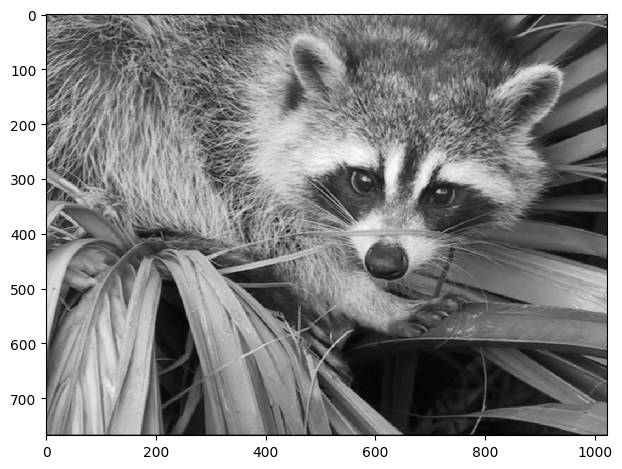

In [8]:
f_face = imread("data/labC_images/face.png")[:,:,:3]
f_face = rgb2gray(f_face)

def box(m):      
    n = m                         # Larger filter -> Larger padding
    return (1/(m*n))*np.ones([m,n])    

w1 = box(3)

g1_face = twodCorrelate(f_face,w1)
g2_face = twodConvolve(f_face,w1)

imshow(g1_face)                 # Strange green hue if image a float out of range [0,1]

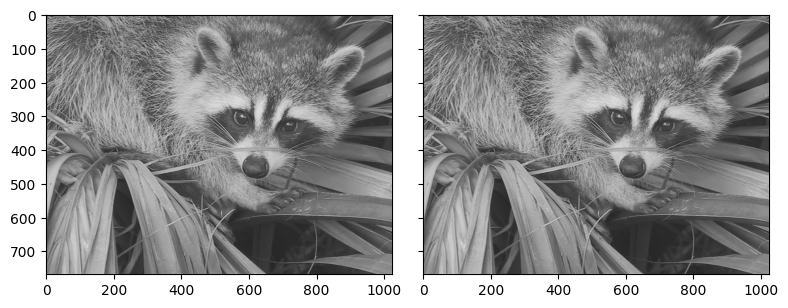

In [9]:
w2 = np.array([[0,-1,0],       # Caution dtype='uint8' cant be negative
               [-1,8,-1],
               [0,-1,0]])

g_test1 = twodCorrelate(f_face,w2)
g_test2 = convolve2d(f_face,w2)

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8), sharex=True, sharey=True)
ax=axes.ravel()
ax[0].imshow(g_test1,cmap='gray')        # Plot as greyscale image
ax[1].imshow(g_test1,cmap='gray')
fig.tight_layout()
plt.show()

## Question 1b

In [10]:
w3 = np.array([[0,-1,np.sqrt(2)],   # Caution dtype='uint8' cant be negative
               [1, 1,        -1],
               [-np.sqrt(2),1,0]])

g3_face = twodCorrelate(f_face,w3)
g4_face = twodConvolve(f_face,w3)

g3_result = exposure.rescale_intensity(g3_face-g4_face)     # Image arithmatic must take place in float to allow out of range.
                                                            # Do scaling or clipping at end if needed.
                                                            # Grey image means black was shifted up due to the negatives 
                                                            # being moved to zero. 

## Question 1c

In [11]:
w4 = np.flip(w3,axis = (0,1))
g5_face = twodCorrelate(f_face,w4)

g5_result = exposure.rescale_intensity(g4_face-g5_face)    # Scale to [0,1]

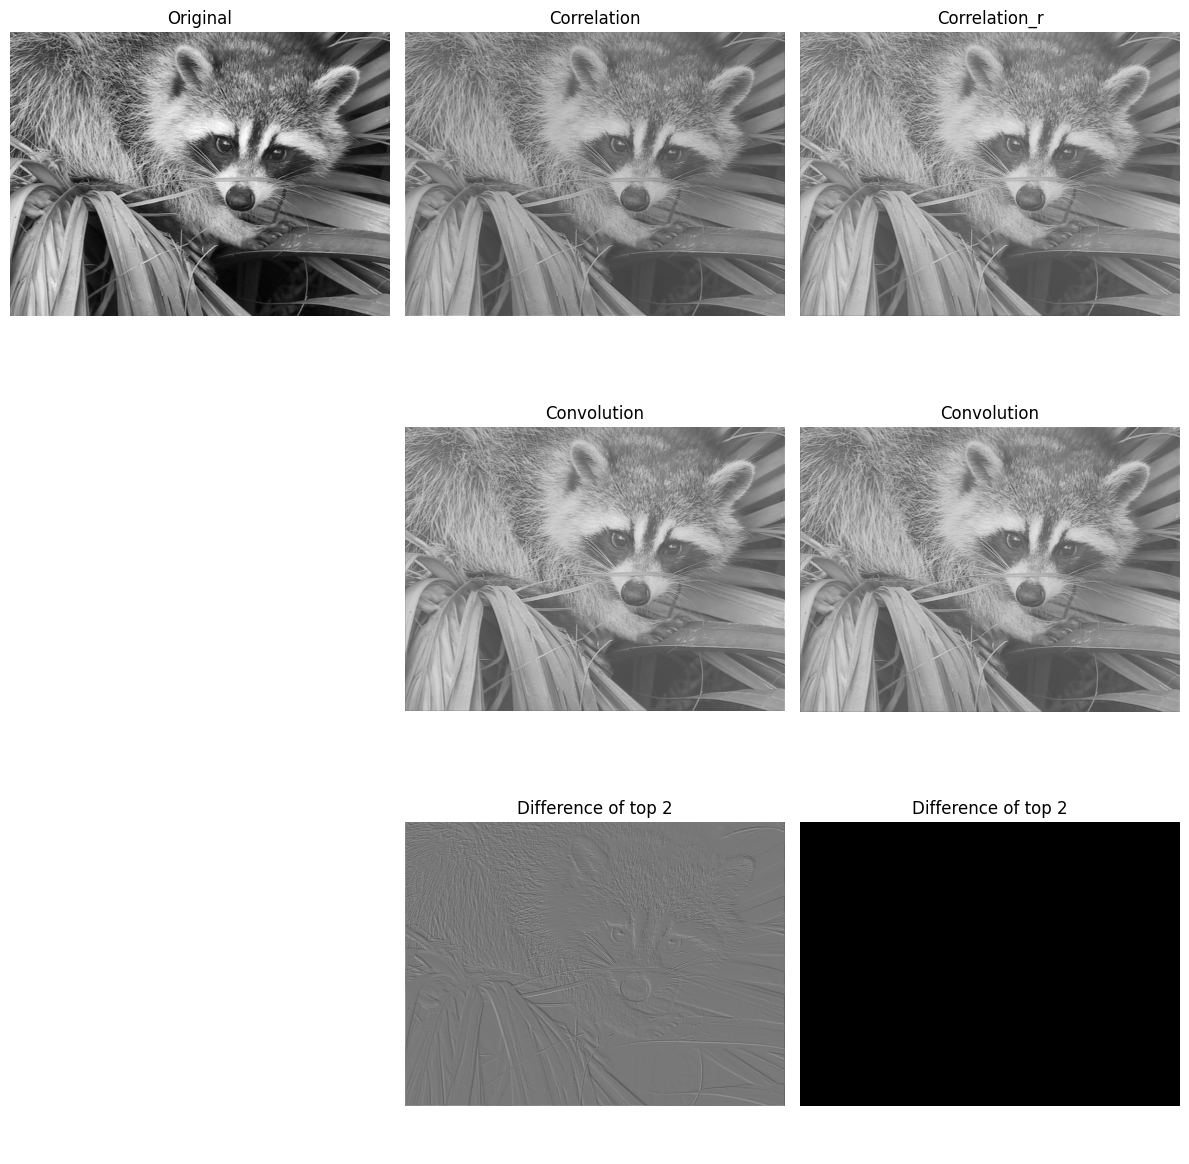

In [12]:
fig,axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex=True, sharey=True)
ax=axes.ravel()
ax[0].imshow(f_face,cmap='gray')        # Plot as greyscale image
ax[0].set_title('Original')

ax[1].imshow(g3_face,cmap='gray')
ax[1].set_title('Correlation')

ax[2].imshow(g5_face,cmap='gray')
ax[2].set_title('Correlation_r')

ax[4].imshow(g4_face,cmap='gray')
ax[4].set_title('Convolution')

ax[5].imshow(g4_face,cmap='gray')
ax[5].set_title('Convolution')

ax[7].imshow(g3_result,cmap='gray')
ax[7].set_title('Difference of top 2')

ax[8].imshow(g5_result,cmap='gray')
ax[8].set_title('Difference of top 2')

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

## Question 2

In [13]:
def gaussian2DFilter(shape,sigma):

    w = np.zeros(shape)
    x_mid = shape[0]//2
    y_mid = shape[0]//2
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            x = i-x_mid
            y = j-y_mid
            w[i,j] = np.exp(-((x**2+y**2)/(2*sigma**2)))
            
    w = w/np.sum(w)      # Normalise filter
    
    return w

In [14]:
gaussian2DFilter([5,5],1)

array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]])

## Question 3

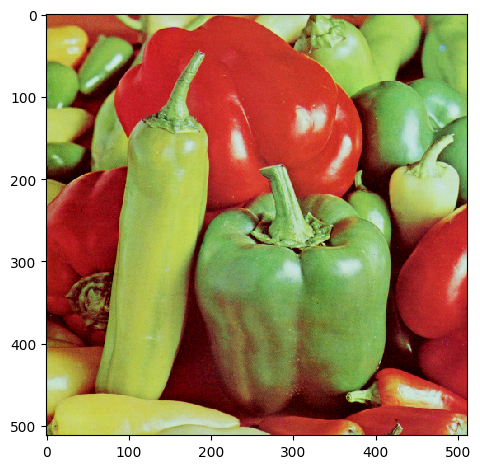

In [15]:
f_pepper = io.imread("data/labC_images/pepper.tiff")
imshow(f_pepper)

In [16]:
g1_pepper = np.stack([twodConvolve(f_pepper[:,:,0],box(5)),twodConvolve(f_pepper[:,:,1],box(5)),twodConvolve(f_pepper[:,:,2],box(5))],-1)
g1_pepper = exposure.rescale_intensity(g1_pepper)
g2_pepper = np.stack([twodConvolve(f_pepper[:,:,0],box(13)),twodConvolve(f_pepper[:,:,1],box(13)),twodConvolve(f_pepper[:,:,2],box(13))],-1)
g2_pepper = exposure.rescale_intensity(g2_pepper)
g3_pepper = np.stack([twodConvolve(f_pepper[:,:,0],box(21)),twodConvolve(f_pepper[:,:,1],box(21)),twodConvolve(f_pepper[:,:,2],box(21))],-1)
g3_pepper = exposure.rescale_intensity(g3_pepper)

In [17]:
g4_pepper = np.stack([twodConvolve(f_pepper[:,:,0],gaussian2DFilter([5,5],1)),twodConvolve(f_pepper[:,:,1],gaussian2DFilter([5,5],1)),twodConvolve(f_pepper[:,:,2],gaussian2DFilter([5,5],1))],-1)
g4_pepper = exposure.rescale_intensity(g4_pepper)
g5_pepper = np.stack([twodConvolve(f_pepper[:,:,0],gaussian2DFilter([13,13],2)),twodConvolve(f_pepper[:,:,1],gaussian2DFilter([13,13],2)),twodConvolve(f_pepper[:,:,2],gaussian2DFilter([13,13],2))],-1)
g5_pepper = exposure.rescale_intensity(g5_pepper)
g6_pepper = np.stack([twodConvolve(f_pepper[:,:,0],gaussian2DFilter([21,21],3.5)),twodConvolve(f_pepper[:,:,1],gaussian2DFilter([21,21],3.5)),twodConvolve(f_pepper[:,:,2],gaussian2DFilter([21,21],3.5))],-1)
g6_pepper = exposure.rescale_intensity(g6_pepper)

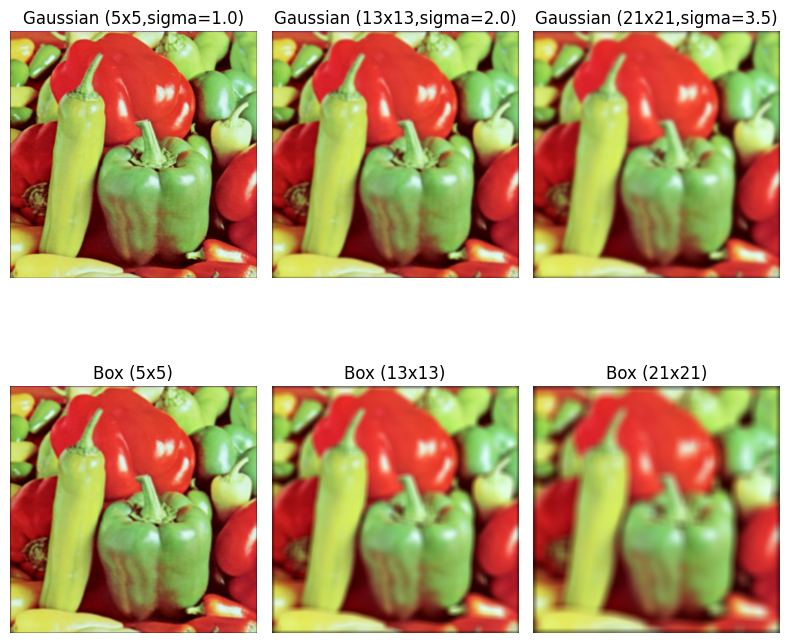

In [18]:
fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(8,8), sharex=True, sharey=True)
ax=axes.ravel()
ax[0].imshow(g4_pepper)
ax[0].set_title('Gaussian (5x5,sigma=1.0)')

ax[1].imshow(g5_pepper)
ax[1].set_title('Gaussian (13x13,sigma=2.0)')

ax[2].imshow(g6_pepper)
ax[2].set_title('Gaussian (21x21,sigma=3.5)')

ax[3].imshow(g1_pepper)
ax[3].set_title('Box (5x5)')

ax[4].imshow(g2_pepper)
ax[4].set_title('Box (13x13)')

ax[5].imshow(g3_pepper)
ax[5].set_title('Box (21x21)')

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

## Question 4

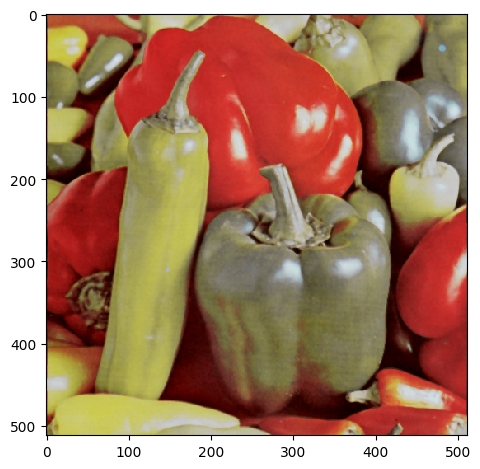

In [19]:
h_pepper = median_filter(f_pepper,size=3)
imshow(h_pepper)

## Question 5

/home/marcelln/Digital-Image-Processing/.venv/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


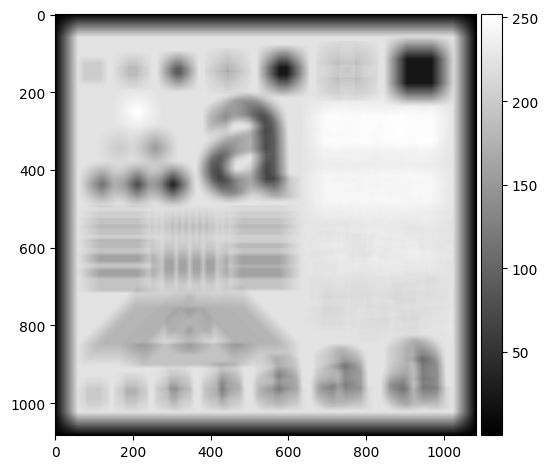

In [20]:
f_pattern = io.imread("data/labC_images/testpattern1024.tif")
g_pattern = convolve2d(f_pattern,box(60))
imshow(g_pattern, cmap='gray')

## Question 6

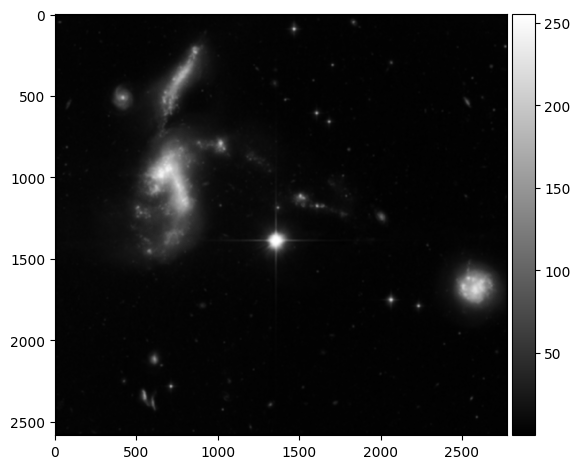

In [21]:
f_hick = io.imread("data/labC_images/hickson-compact-group.tif")
g_hick = convolve2d(f_hick,gaussian2DFilter((20,20),5))
imshow(g_hick,cmap='gray')

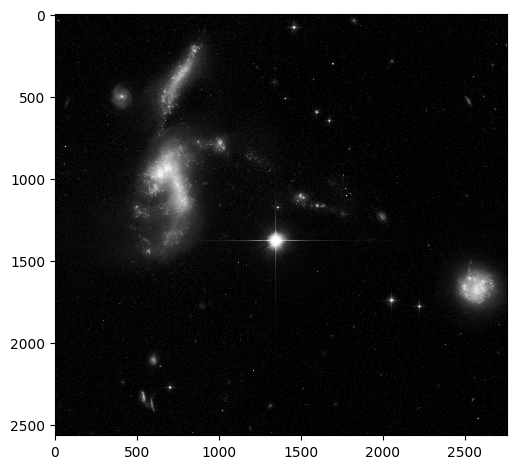

In [22]:
imshow(f_hick)

## Question 7

In [23]:
f_check = imread("data/labC_images/checkerboard1024.tif")
g_check = convolve2d(f_check,box(128),mode='valid')   # Averages out the squares equally at all positions - Valid = trims
                                                      # Black due to automatic contrast stretching

In [24]:
g_check

array([[127.5, 127.5, 127.5, ..., 127.5, 127.5, 127.5],
       [127.5, 127.5, 127.5, ..., 127.5, 127.5, 127.5],
       [127.5, 127.5, 127.5, ..., 127.5, 127.5, 127.5],
       ...,
       [127.5, 127.5, 127.5, ..., 127.5, 127.5, 127.5],
       [127.5, 127.5, 127.5, ..., 127.5, 127.5, 127.5],
       [127.5, 127.5, 127.5, ..., 127.5, 127.5, 127.5]])

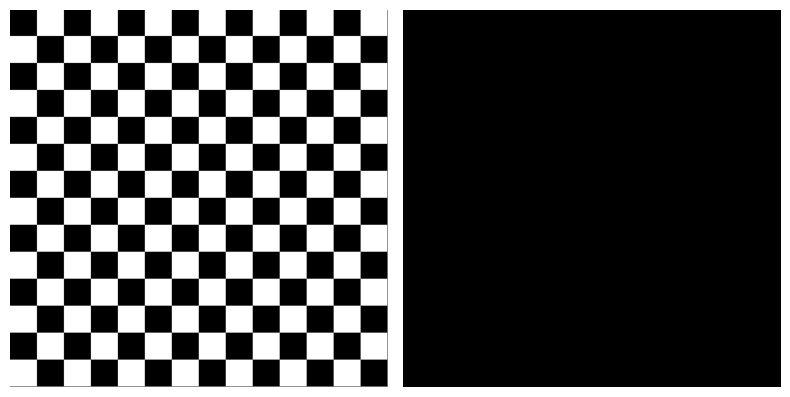

In [25]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8), sharex=True, sharey=True)
ax=axes.ravel()
ax[0].imshow(f_check,cmap='gray')        # Plot as greyscale image
ax[0].axis('off')
ax[1].imshow(g_check,cmap='gray')
ax[1].axis('off')
fig.tight_layout()
plt.show()

## Question 8

In [26]:
f_camera = io.imread("data/labC_images/cameraman.tif")
f_camera = exposure.rescale_intensity(f_camera,'image',(0,1))   # Work in range [0,1]

w4 = np.array([[-1,-1,-1],       
               [-1,+8,-1],
               [-1,-1,-1]])

g_camera1 = convolve2d(f_camera,w4)
g_camera2 = g_camera1*255
g_camera3 = g_camera1*255

In [27]:
g_camera3

array([[-154.45121951, -312.01219512, -468.53658537, ..., -449.87804878,
        -300.6097561 , -150.30487805],
       [-313.04878049,  767.07317073,  483.04878049, ...,  445.73170732,
         747.37804878, -301.64634146],
       [-467.5       ,  492.37804878,  -32.13414634, ...,   23.84146341,
         456.09756098, -451.95121951],
       ...,
       [-347.25609756,  340.        ,   11.40243902, ...,   33.17073171,
         268.47560976, -330.67073171],
       [-236.34146341,  580.48780488,  372.13414634, ...,  411.52439024,
         514.14634146, -219.75609756],
       [-118.17073171, -241.52439024, -369.02439024, ..., -367.98780488,
        -237.37804878, -109.87804878]])

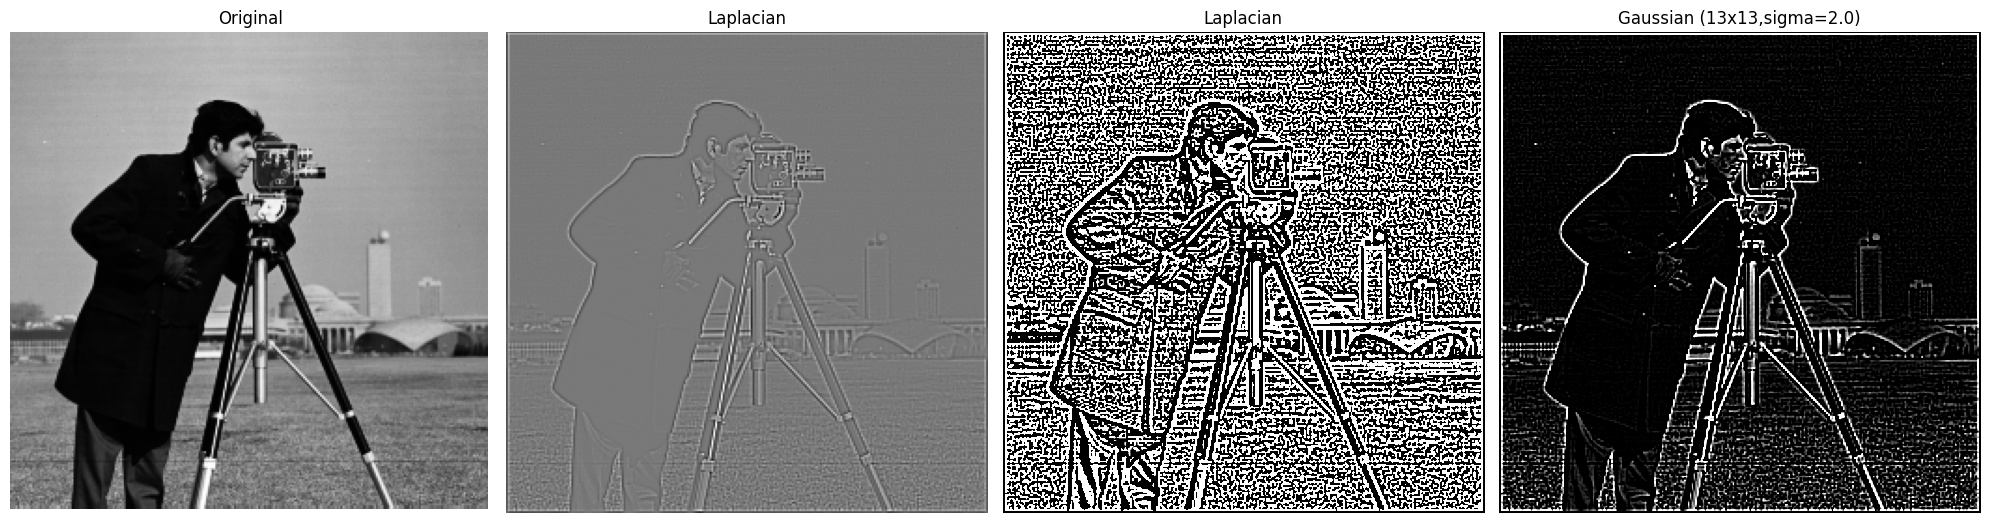

In [28]:
fig,axes = plt.subplots(nrows=1, ncols=4, figsize=(20,8), sharex=True, sharey=True)
ax=axes.ravel()
ax[0].imshow(f_camera, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(g_camera1, cmap='gray')
ax[1].set_title('Laplacian')

ax[2].imshow(g_camera2, cmap='gray', vmin=0, vmax=1)     # Clip negatives and 1-255
ax[2].set_title('Laplacian')

ax[3].imshow(g_camera3, cmap='gray', vmin=0, vmax=255)   # Clip negatives
ax[3].set_title('Gaussian (13x13,sigma=2.0)')

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

## Question 9

In [29]:
f_lena1 = exposure.rescale_intensity(io.imread("data/labC_images/lena_gaussian.png"),'image',(0,1))
f_lena2 = exposure.rescale_intensity(io.imread("data/labC_images/lena_SnP.png"),'image',(0,1))
f_lena3 = exposure.rescale_intensity(io.imread("data/labC_images/lena_speckle.png"),'image',(0,1))
f_lena4 = exposure.rescale_intensity(io.imread("data/labC_images/lena_rayleigh.png"),'image',(0,1))
f_lena5 = exposure.rescale_intensity(io.imread("data/labC_images/lena_uniform.png"),'image',(0,1))

In [30]:
f_lena6 = convolve2d(f_lena1,box(5))
f_lena7 = convolve2d(f_lena2,box(5))
f_lena8 = convolve2d(f_lena3,box(5))
f_lena9 = convolve2d(f_lena4,box(5))
f_lena10 = convolve2d(f_lena5,box(5))

In [31]:
f_lena11 = median_filter(f_lena1,(5,5))
f_lena12 = median_filter(f_lena2,(5,5))
f_lena13 = median_filter(f_lena3,(5,5))
f_lena14 = median_filter(f_lena4,(5,5))
f_lena15 = median_filter(f_lena5,(5,5))

In [32]:
n_lena = exposure.rescale_intensity(imread("data/labC_images/lena-RGB.tif"),'image',(0,1))
n_lena = rgb2gray(n_lena) 

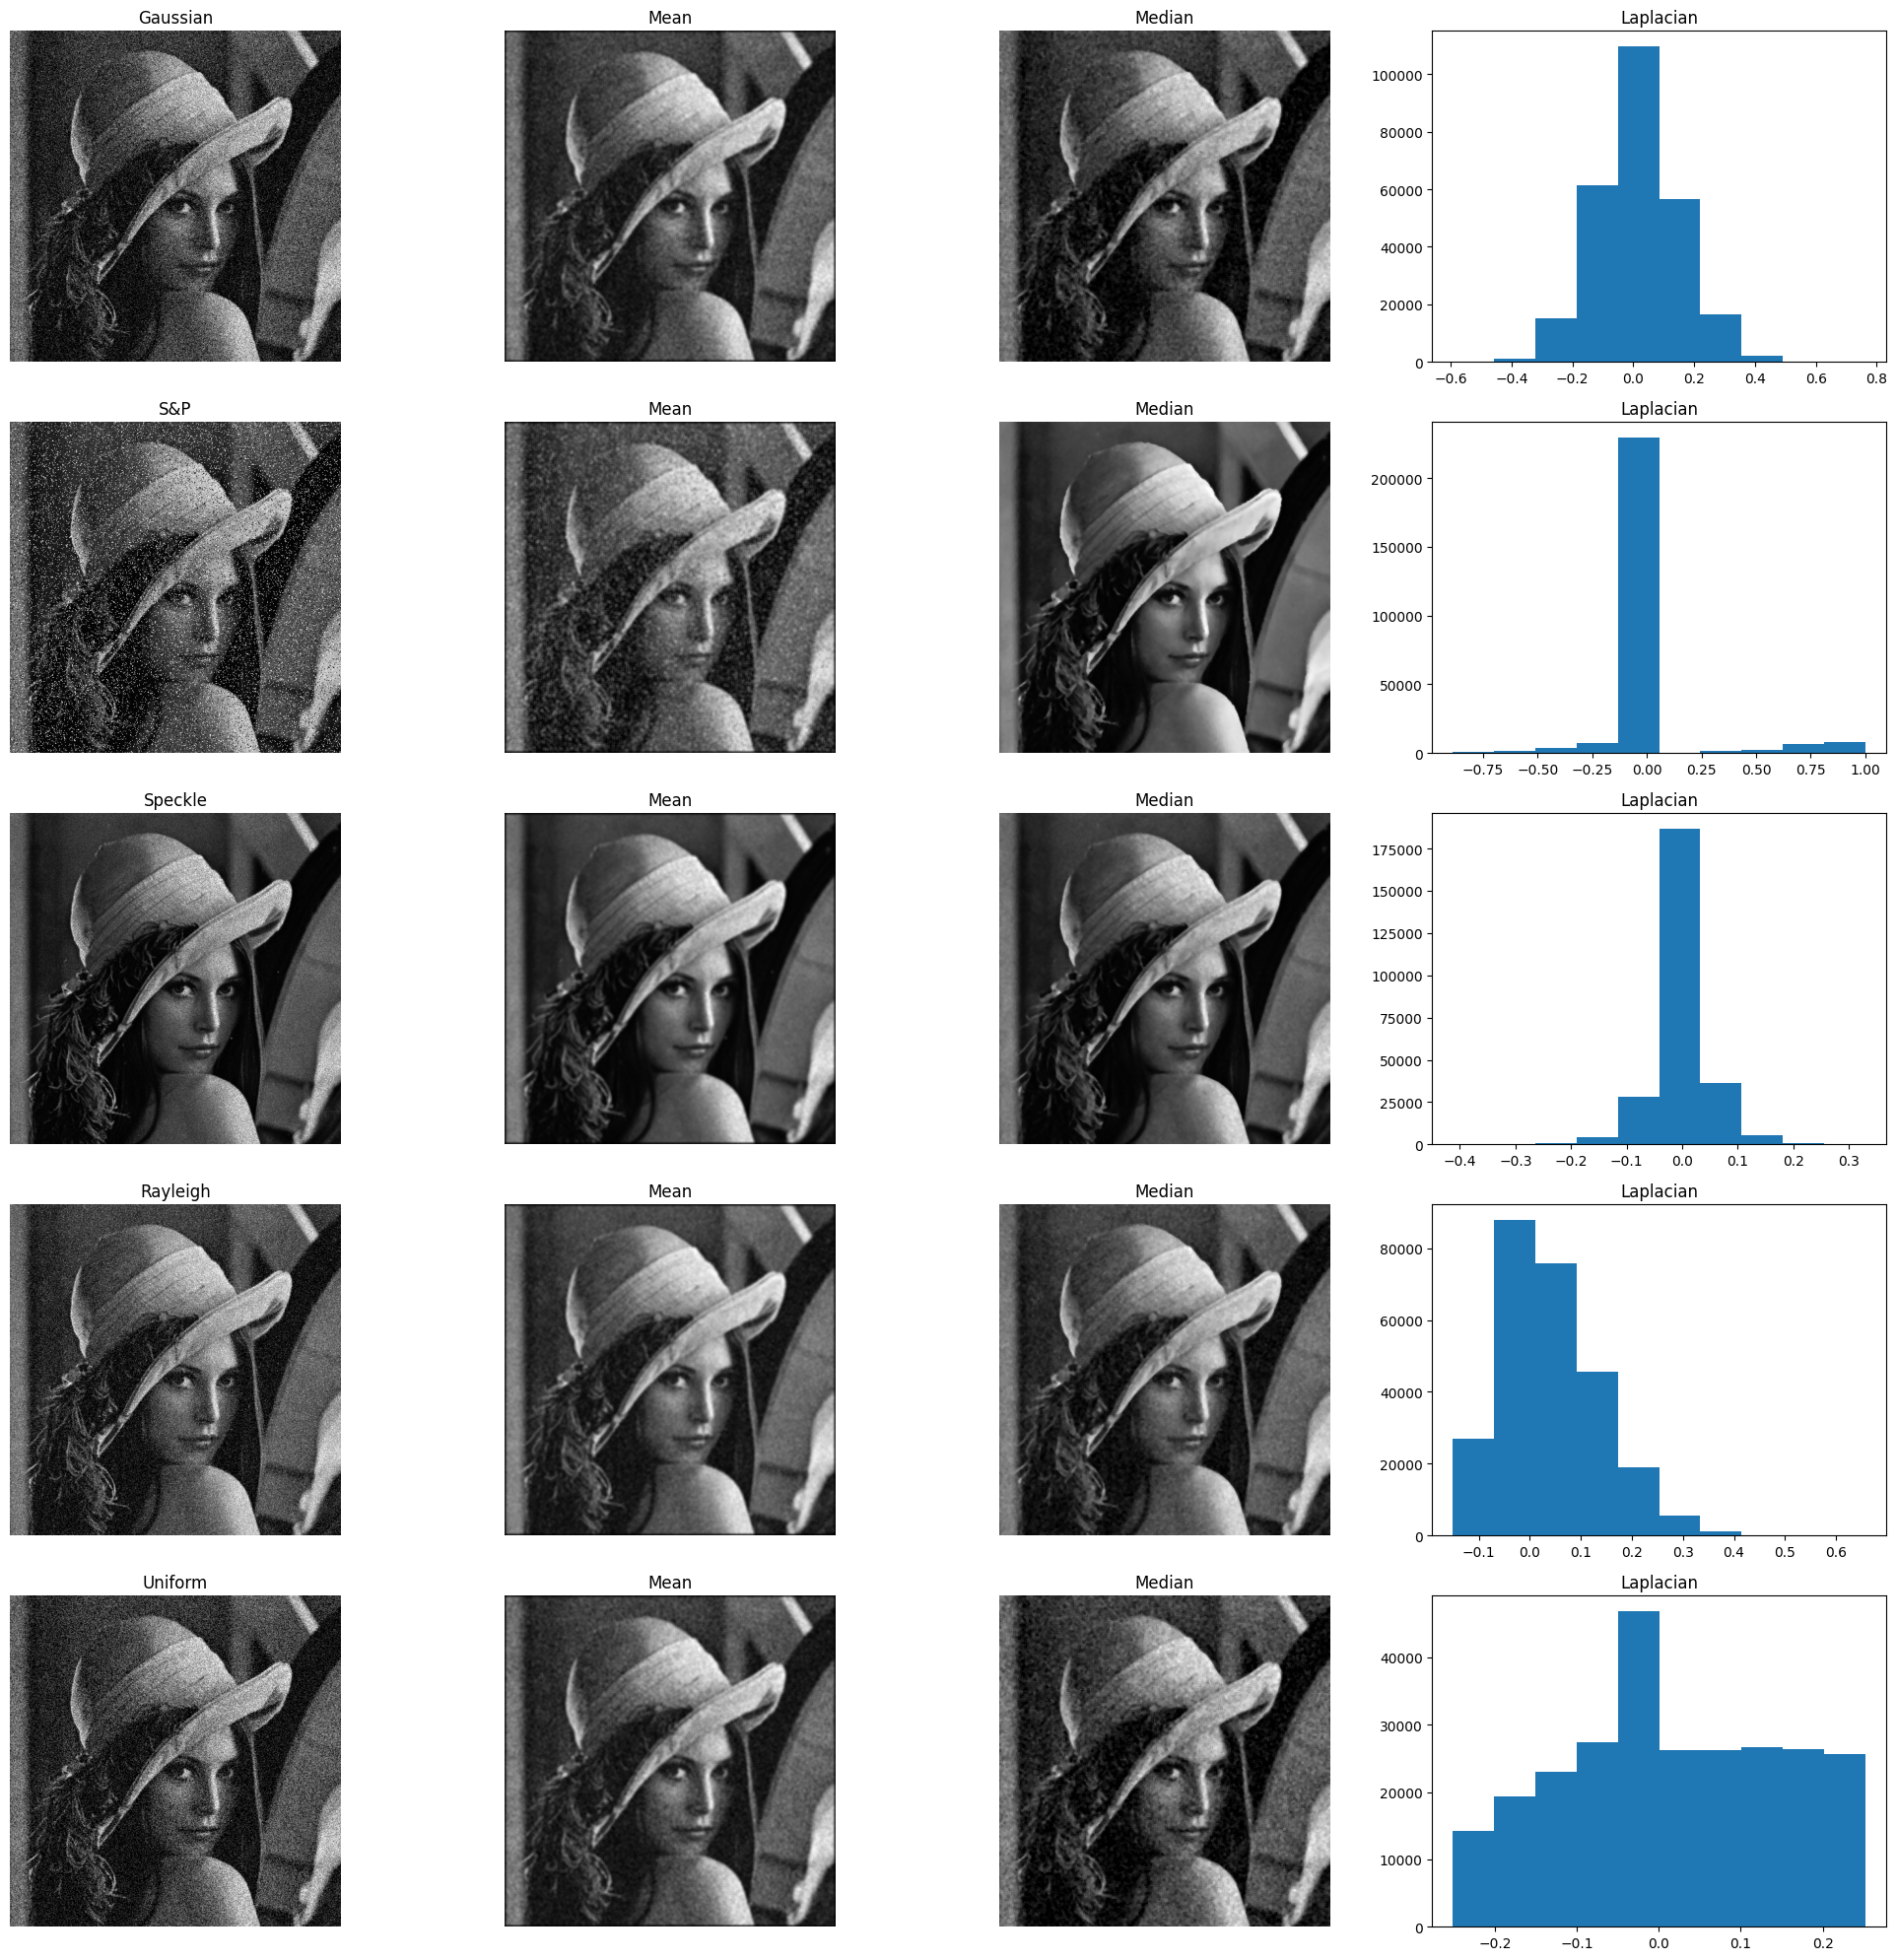

In [33]:
fig,axes = plt.subplots(nrows=5, ncols=4, figsize=(20,20))
ax=axes.ravel()
ax[0].imshow(f_lena1, cmap='gray')
ax[0].set_title('Gaussian')

ax[1].imshow(f_lena6, cmap='gray')
ax[1].set_title('Mean')

ax[2].imshow(f_lena11, cmap='gray')
ax[2].set_title('Median')

ax[4].imshow(f_lena2, cmap='gray')
ax[4].set_title('S&P')

ax[5].imshow(f_lena7, cmap='gray')
ax[5].set_title('Mean')

ax[6].imshow(f_lena12, cmap='gray')
ax[6].set_title('Median')

ax[8].imshow(f_lena3, cmap='gray')
ax[8].set_title('Speckle')

ax[9].imshow(f_lena8, cmap='gray')
ax[9].set_title('Mean')

ax[10].imshow(f_lena13, cmap='gray')
ax[10].set_title('Median')

ax[12].imshow(f_lena4, cmap='gray')
ax[12].set_title('Rayleigh')

ax[13].imshow(f_lena9, cmap='gray')
ax[13].set_title('Mean')

ax[14].imshow(f_lena14, cmap='gray')
ax[14].set_title('Median')

ax[16].imshow(f_lena5, cmap='gray')
ax[16].set_title('Uniform')

ax[17].imshow(f_lena10, cmap='gray')
ax[17].set_title('Mean')

ax[18].imshow(f_lena15, cmap='gray')
ax[18].set_title('Median')

for a in ax:
    a.axis('off')
    
ax[3].hist(np.ravel(f_lena1-n_lena),bins=10)
ax[3].set_title('Laplacian')
ax[3].axis('on')

ax[7].hist(np.ravel(f_lena2-n_lena),bins=10)
ax[7].set_title('Laplacian')
ax[7].axis('on')

ax[11].hist(np.ravel(f_lena3-n_lena),bins=10)
ax[11].set_title('Laplacian')
ax[11].axis('on')

ax[15].hist(np.ravel(f_lena4-n_lena),bins=10)
ax[15].set_title('Laplacian')
ax[15].axis('on')

ax[19].hist(np.ravel(f_lena5-n_lena),bins=10)
ax[19].set_title('Laplacian')
ax[19].axis('on')

fig.tight_layout()
plt.show()